## Imports

In [64]:
import numpy as np
from scipy.io import loadmat
import shapely as sh
from shapely.geometry import Point
import matplotlib.pyplot as plt
import geopandas as gpd

import tensorflow as tf
import tensorflow.math as math
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import Accuracy, RootMeanSquaredError, MeanAbsoluteError
from tensorflow.keras.callbacks import LearningRateScheduler, TensorBoard
from tensorflow.keras.models import Model
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.layers import Input, Conv3D, MaxPooling3D, Conv3DTranspose, BatchNormalization, Activation, \
    Concatenate
import os
from sklearn.model_selection import train_test_split
import time
%matplotlib inline

## Data loading and preprocessing

Specify paths to the training data

In [65]:
# For working remotely on CIP machines
dspl_path = '/home/r/richard/Downloads/train/trainData104/dspl'
dsplRadial_path = '/home/r/richard/Downloads/train/trainData104/dsplRadial'
trac_path = '/home/r/richard/Downloads/train/trainData104/trac'
tracRadial_path = '/home/r/richard/Downloads/train/trainData104/tracRadial'

# Paths to small subsets of original data for bug fixing
foo_dspl_path = '/home/r/richard/Downloads/train/trainData104/foo_dspl'
foo_dsplRadial_path = '/home/r/richard/Downloads/train/trainData104/foo_dsplRadial'
foo_trac_path = '/home/r/richard/Downloads/train/trainData104/foo_trac'
foo_tracRadial_path = '/home/r/richard/Downloads/train/trainData104/foo_tracRadial'

In [66]:
# For working on Martinsried machine
# dspl_path = '/home/alexrichard/LRZ Sync+Share/ML in Physics/data/train/trainData104/dspl'
# dsplRadial_path = '/home/alexrichard/LRZ Sync+Share/ML in Physics/data/train/trainData104/dsplRadial'
# trac_path = '/home/alexrichard/LRZ Sync+Share/ML in Physics/data/train/trainData104/trac'
# tracRadial_path = '/home/alexrichard/LRZ Sync+Share/ML in Physics/data/train/trainData104/tracRadial'

# Paths to small subsets of original data for bug fixing
# foo_dspl_path = '/home/alexrichard/LRZ Sync+Share/ML in Physics/data/train/trainData104/foo_dspl'
# foo_dsplRadial_path = '/home/alexrichard/LRZ Sync+Share/ML in Physics/data/train/trainData104/foo_dsplRadial'
# foo_trac_path = '/home/alexrichard/LRZ Sync+Share/ML in Physics/data/train/trainData104/foo_trac'
# foo_tracRadial_path = '/home/alexrichard/LRZ Sync+Share/ML in Physics/data/train/trainData104/foo_tracRadial'

`datasets` saves the training and test data in arrays of dictionaries of the form {'brdx': array, 'brdy': array, 'dspl' or 'trac' = array, 'name': String}

In [67]:
def datasets(dspl_path, dsplRadial_path, trac_path, tracRadial_path):
    number_samples = len([name for name in os.listdir(dspl_path) if os.path.isfile(os.path.join(dspl_path, name))])
    number_radials = len([name for name in os.listdir(dsplRadial_path) if os.path.isfile(os.path.join(dsplRadial_path, name))])
    
    # save all samples in matrix
    samples = [] 
    for i, filename in enumerate(os.listdir(dspl_path)):
        f = os.path.join(dspl_path, filename)
        if os.path.isfile(f):
            sample = loadmat(f)
            if '__header__' in sample: del sample['__header__']
            if '__version__' in sample: del sample['__version__']
            if '__globals__' in sample: del sample['__globals__']
            sample['name'] = filename
            samples = np.append(samples, sample)
        else:
            continue
    samples = np.array(samples)

    # save all radial patterns of displacements in matrix
    dspl_radials = []
    for i, filename in enumerate(os.listdir(dsplRadial_path)):
        f = os.path.join(dsplRadial_path, filename)
        if os.path.isfile(f):
            radial = loadmat(f)
            if '__header__' in radial: del radial['__header__']
            if '__version__' in radial: del radial['__version__']
            if '__globals__' in radial: del radial['__globals__']
            radial['name'] = filename
            dspl_radials = np.append(dspl_radials, radial)
        else:
            continue
    dspl_radials = np.array(dspl_radials)
    
    # save all targets in matrix
    targets = []
    for i, filename in enumerate(os.listdir(trac_path)):
        f = os.path.join(trac_path, filename)
        if os.path.isfile(f):
            target = loadmat(f)
            if '__header__' in target: del target['__header__']
            if '__version__' in target: del target['__version__']
            if '__globals__' in target: del target['__globals__']
            target['name'] = filename
            targets = np.append(targets, target)
        else:
            continue 
    targets = np.array(targets)
    
    # save all radial patterns of traction forces in matrix
    trac_radials = []
    for i, filename in enumerate(os.listdir(tracRadial_path)):
        f = os.path.join(tracRadial_path, filename)
        if os.path.isfile(f):
            radial = loadmat(f)
            if '__header__' in radial: del radial['__header__']
            if '__version__' in radial: del radial['__version__']
            if '__globals__' in radial: del radial['__globals__']
            radial['name'] = filename
            trac_radials = np.append(trac_radials, radial)
        else:
            continue
    trac_radials = np.array(trac_radials)

    return samples, dspl_radials, targets, trac_radials

Set seed for reproducability and generate the training, validation and test data

In [68]:
np.random.seed(123)

samples, dspl_radials, targets, trac_radials = datasets(foo_dspl_path, foo_dsplRadial_path, foo_trac_path, foo_tracRadial_path)
samples, targets = np.append(samples, dspl_radials), np.append(targets, trac_radials)

X, y = np.array([sample['dspl'] for sample in samples]), np.array([target['trac'] for target in targets])

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = X_train.reshape(((len(X_train), 104, 104, 2, 1))), X_val.reshape(((len(X_val), 104, 104, 2, 1))), y_train.reshape(((len(y_train), 104, 104, 2, 1))), y_val.reshape(((len(y_val), 104, 104, 2, 1)))

## Build model

Specify the name and logs of the current model

In [91]:
NAME = "TracNet104-{}".format(int(time.time()))
tensorboard = TensorBoard(log_dir='logs/{}'.format(NAME))

In [92]:
def conv_block(input, num_filters, snd_batch_normalization=True):
    initializer = RandomNormal(mean=0.0, stddev=0.01)
    x = Conv3D(filters=num_filters, kernel_size=(3, 3, 2), padding='same', kernel_initializer=initializer,
               bias_initializer='zeros')(input)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Conv3D(filters=num_filters, kernel_size=(3, 3, 2), padding='same', kernel_initializer=initializer,
               bias_initializer='zeros')(x)
    if snd_batch_normalization:
        x = BatchNormalization()(x)
    x = Activation("relu")(x)

    return x

In [93]:
def encoder_block(input, num_filters):
    x = conv_block(input, num_filters, snd_batch_normalization=False)
    p = MaxPooling3D(pool_size=(2, 2, 1), strides=(2, 2, 1), padding='same')(x)

    return x, p

In [94]:
def decoder_block(input, skip_features, num_filters):
    initializer = RandomNormal(mean=0.0, stddev=0.01)
    x = Conv3DTranspose(filters=num_filters, kernel_size=(3, 3, 1), strides=(2, 2, 1),
                        kernel_initializer=initializer, bias_initializer='zeros', padding='same')(input)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters, snd_batch_normalization=True)

    return x

In [95]:
def build_tracnet(input_shape, batch_size):
    # entry point into graph of layers
    inputs = Input(shape=input_shape, batch_size=batch_size)

    # convolution and max-pooling operations with specified numbers of filters
    s1, p1 = encoder_block(inputs, 32)
    s2, p2 = encoder_block(p1, 64)
    s3, p3 = encoder_block(p2, 128)

    # base
    b1 = conv_block(p3, 256)

    # convolution and upsampling operations with specified numbers of filters
    d1 = decoder_block(b1, s3, 128)
    d2 = decoder_block(d1, s2, 64)
    d3 = decoder_block(d2, s1, 32)

    # output
    initializer = RandomNormal(mean=0.0, stddev=0.01)
    outputs = Conv3D(filters=1, kernel_size=(3, 3, 2), padding='same', kernel_initializer=initializer,
                     bias_initializer='zeros')(d3)

    # build model
    model = Model(inputs, outputs, name=NAME)

    return model

## Training

In [96]:
def log_half_mse(y_true, y_pred):
    result = math.log(0.5 * math.reduce_sum(math.pow(y_true - y_pred, 2)))
    print(type(result))
    print(result)
    return result

In [97]:
def lr_step_decay(epoch):
    initial_lr = 6e-4
    drop_rate = 0.7943
    epochs_drop = 10.0
    
    return initial_lr * np.power(drop_rate, np.floor(epoch/epochs_drop))

In [100]:
def train_tracnet(X_train, X_val, y_train, y_val, input_shape=(104, 104, 2, 1), epochs=50):
    batch_size = 3
    # Input layer expects (batch size, length, width, depth, channels)
    class haltCallback(tf.keras.callbacks.Callback):
        def on_epoch_end(self, epoch, logs={}):
            if(logs.get('mse') < 3):
                print("\n\n\nLoss value below 3 so cancelling training!\n\n\n")
                self.model.stop_training = True
                
    trainingStopCallback = haltCallback()
    
    model = build_tracnet(input_shape, batch_size)
    model.compile(
        optimizer=SGD(momentum=0.9),
        loss = log_half_mse,
        metrics=['accuracy', log_half_mse],
        run_eagerly=True
    )
    
    model.summary()
    
    history = model.fit(
    X_train,
    y_train,
    validation_data=(X_val, y_val),
    batch_size=batch_size,
    epochs=epochs,
    callbacks=[LearningRateScheduler(lr_step_decay, verbose=2), tensorboard],
    verbose=2
    )

    # plot accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

    # plot loss
    plt.plot(history.history['log_half_mse'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()
    
    # save model
    model.save("{}.tf".format(NAME),save_format='tf',include_optimizer=True)
    
    return model

Model: "TracNet104-1646854099"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(3, 104, 104, 2, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv3d_45 (Conv3D)             (3, 104, 104, 2, 32  608         ['input_4[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_33 (BatchN  (3, 104, 104, 2, 32  128        ['conv3d_45[0][0]']              
 ormalization)                  )                                             

<class 'tensorflow.python.framework.ops.EagerTensor'>
tf.Tensor(7.3025346, shape=(), dtype=float32)
<class 'tensorflow.python.framework.ops.EagerTensor'>
tf.Tensor(7.3025346, shape=(), dtype=float32)
<class 'tensorflow.python.framework.ops.EagerTensor'>
tf.Tensor(7.2338004, shape=(), dtype=float32)
<class 'tensorflow.python.framework.ops.EagerTensor'>
tf.Tensor(7.2338004, shape=(), dtype=float32)
<class 'tensorflow.python.framework.ops.EagerTensor'>
tf.Tensor(6.034159, shape=(), dtype=float32)
<class 'tensorflow.python.framework.ops.EagerTensor'>
tf.Tensor(6.034159, shape=(), dtype=float32)
<class 'tensorflow.python.framework.ops.EagerTensor'>
tf.Tensor(7.15193, shape=(), dtype=float32)
<class 'tensorflow.python.framework.ops.EagerTensor'>
tf.Tensor(7.15193, shape=(), dtype=float32)
<class 'tensorflow.python.framework.ops.EagerTensor'>
tf.Tensor(7.263746, shape=(), dtype=float32)
<class 'tensorflow.python.framework.ops.EagerTensor'>
tf.Tensor(7.263746, shape=(), dtype=float32)
<class '

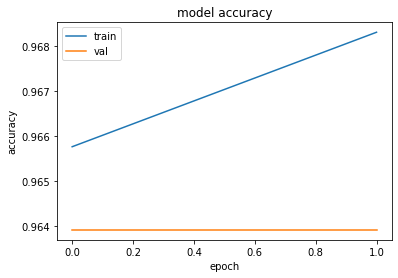

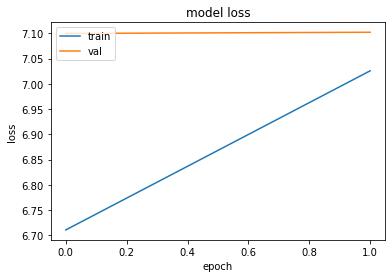

INFO:tensorflow:Assets written to: TracNet104-1646854099.tf/assets


In [101]:
model = train_tracnet(X_train, X_val, y_train, y_val, epochs=2)

In [49]:
tf.keras.utils.plot_model?

In [50]:
X_val.shape
array_sum = np.sum(X_val)
array_has_nan = np.isnan(array_sum)
array_has_nan

False

In [51]:
x_pred = model.predict(X_val)

In [52]:
y_val.shape

(5, 104, 104, 2, 1)

In [53]:
y1 = tf.convert_to_tensor(y_val[0])
y2 = tf.convert_to_tensor(y_val[1])

In [54]:
math.reduce_sum(math.pow(y1 - y2, 2))

<tf.Tensor: shape=(), dtype=float64, numpy=0.3895296000000089>

In [55]:
math.reduce_sum(math.pow(y1 - y2, 2))

<tf.Tensor: shape=(), dtype=float64, numpy=0.3895296000000089>

In [56]:
x = 0.5 * math.reduce_sum(math.pow(y1 - y2, 2))

In [57]:
c = tf.constant([[1.0, 2.0], [3.0, 4.0]])
d = tf.constant([[1.0, 1.0], [0.0, 1.0]])
e = tf.matmul(c, d)
f = tf.constant([[5.0, 6.0], [7.0, 8.0]])
g = tf.constant([[1.0, 2.0], [3.0, 4.0]])
h = tf.matmul(f, g)

In [58]:
e, h

(<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
 array([[1., 3.],
        [3., 7.]], dtype=float32)>,
 <tf.Tensor: shape=(2, 2), dtype=float32, numpy=
 array([[23., 34.],
        [31., 46.]], dtype=float32)>)

In [59]:
math.reduce_sum(math.pow(e - h, 2))

<tf.Tensor: shape=(), dtype=float32, numpy=3750.0>

## Error calculation

For a given displacement field, calculate the predicted stress field and the normalized rmse relative to its ground truth for different Young's moduli.

In [60]:
def calcError(path):
    errors = []
    S = 160
    y_moduli = [2500, 5000, 10000, 20000, 400000]
    noise = 0.00765
    for nr in range(18, 56):
        name = f'MLData00{nr}.mat'.format
        path = os.path.join(path, name)
        if os.path.isfile(path):
            cell = [nr]
            trac_file = loadmat(path)
            brdx = trac_file['brdx']
            brdy = trac_file['brdy']
            tracGT = trac_file['tracGT']
            for i in y_moduli:
                name = f'MLData00{nr}-{i}.mat'.format(nr=nr, i=i)
                path = os.path.join(path, name)
                if os.path.isfile(path):
                    dspl_file = loadmat(path)
                    dspl = dspl_file['dspl']
                    trac = predictTrac(dspl, i)
                    err = errorTrac(trac, tracGT, brdx, brdy)
                    cell.append(err)

                    dspl = addNoise(dspl, noise)
                    trac = predictTrac(dspl, i)
                    err = errorTrac(trac, tracGT, brdx, brdy)
                    cell.append(err)
                else:
                    continue
            errors.append(cell)
        else:
            continue
    df = pd.DataFrame(errors, index=['first', 'second'],
                      columns=['File ID', '2,500Pa', '2,500Pa N', '5,000Pa', '5,000Pa N', '10,000Pa', '10,000Pa N',
                               '20,000Pa', '20,000Pa N', '40,000Pa', '40,000Pa N'])
    return df

`errorTrac` is called by `calcError` to actually perform the error calculation given a predicted stress field and the ground truth.

In [61]:
def errorTrac(filepath, filepath_GT, plot=False):
    file = loadmat(filepath)  # load prediction
    file_GT = loadmat(filepath_GT) # load ground truth
    brdx = file['brdx']  # x-values of predicted cell border
    brdy = file['brdy']  # y-values of predicted cell border
    trac = file['trac']
    tracGT = file_GT['trac']
    zipped = np.array(list(zip(brdx[0], brdy[0])))  # array with (x,y) pairs of cell border coordinates
    polygon = sh.geometry.Polygon(zipped)  # create polygon

    interior = np.zeros((file['dspl'].shape[0], file['dspl'].shape[1]), dtype=int)  # create all zero matrix
    for i in range(len(interior)):  # set all elements in interior matrix to 1 that actually lie within the cell
        for j in range(len(interior[i])):
            point = Point(i, j)
            if polygon.contains(point):
                interior[i][j] = 1

    # plot polygons using geopandas
    if plot:
        p = gpd.GeoSeries(polygon)
        p.plot()
        plt.show()

    # update prediction and ground truth by discarding areas outside of cell borders
    trac[:, :, 1] = trac[:, :, 1] * interior
    trac[:, :, 2] = trac[:, :, 2] * interior
    tracGT[:, :, 1] = tracGT[:, :, 1] * interior
    tracGT[:, :, 2] = tracGT[:, :, 2] * interior

    # compute rmse
    mse = np.sum(np.pow((trac[:, :, 1] - tracGT[:, :, 1], 2)), np.pow((trac[:, :, 2] - tracGT[:, :, 2], 2)))
    rmse = np.sqrt(mse)
    msm = np.sum(np.pow(tracGT[:, :, 1], 2) + np.pow(tracGT[:, :, 2], 2))
    rmsm = np.sqrt(msm)
    error = rmse / rmsm

    return error

`add_noise` applies Gaussian noise to a displacement field

In [62]:
def add_noise(dspl, N):
    dsplN = np.zeros(shape=dspl.shape)
    S = dspl.shape[0]
    stdev = N / np.sqrt(2)
    noise = np.random.normal(loc=0, scale=stdev, size=(S, S))
    dsplN[:, :, 1] = dspl[:, :, 1] + noise
    noise = np.random.normal(loc=0, scale=stdev, size=(S, S))
    dsplN[:, :, 2] = dspl[:, :, 2] + noise
    
    return dsplN